# Convolutional Spiking Neural Network with surrogate gradient descent 

In [36]:
## importing the libraries 
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

In [37]:
# Leaky neuron model, overriding the backward pass with a custom function
  # Forward pass: Heaviside function
  # Backward pass: Override Dirac Delta with the ArcTan function
class LeakySurrogate(nn.Module):
  def __init__(self, beta, threshold=1.0):
      super(LeakySurrogate, self).__init__()

      
      self.beta = beta
      self.threshold = threshold
      self.spike_gradient = self.ATan.apply
  
  
  def forward(self, input_, mem):
    spk = self.spike_gradient((mem-self.threshold))  
    reset = (self.beta * spk * self.threshold).detach() 
    mem = self.beta * mem + input_ - reset 
    return spk, mem

  @staticmethod
  class ATan(torch.autograd.Function):
      @staticmethod
      def forward(ctx, mem):
          spk = (mem > 0).float()
          ctx.save_for_backward(mem) 
          return spk

      @staticmethod
      def backward(ctx, grad_output):
          (mem,) = ctx.saved_tensors  
          grad = 1 / (1 + (np.pi * mem).pow_(2)) * grad_output 
          return grad

In [39]:
# dataloader arguments
batch_size = 128
data_path='/mnist_train.csv'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [40]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

In [41]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [42]:
#Parameters
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10
num_steps = 25
beta = 0.95

In [43]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
    
net = Net().to(device)

In [44]:
def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(
    data, targets, epoch,
    counter, iter_counter,
        loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [47]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

In [ ]:
#training loop 

num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        loss_hist.append(loss_val.item())

        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            test_spk, test_mem = net(test_data.view(batch_size, -1))

            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            if counter % 10 == 0:
                train_printer(
                    data, targets, epoch,
                    counter, iter_counter,
                    loss_hist, test_loss_hist,
                    test_data, test_targets)
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 59.28
Test Set Loss: 53.65
Train set accuracy for a single minibatch: 48.44%
Test set accuracy for a single minibatch: 36.72%


Epoch 0, Iteration 10
Train Set Loss: 31.95
Test Set Loss: 28.80
Train set accuracy for a single minibatch: 82.03%
Test set accuracy for a single minibatch: 82.81%


Epoch 0, Iteration 20
Train Set Loss: 21.47
Test Set Loss: 18.04
Train set accuracy for a single minibatch: 85.94%
Test set accuracy for a single minibatch: 82.81%


Epoch 0, Iteration 30
Train Set Loss: 14.51
Test Set Loss: 17.58
Train set accuracy for a single minibatch: 83.59%
Test set accuracy for a single minibatch: 83.59%


Epoch 0, Iteration 40
Train Set Loss: 12.60
Test Set Loss: 10.77
Train set accuracy for a single minibatch: 86.72%
Test set accuracy for a single minibatch: 88.28%


Epoch 0, Iteration 50
Train Set Loss: 11.84
Test Set Loss: 10.51
Train set accuracy for a single minibatch: 87.50%
Test set accuracy for a single minibatch: 81.25%


Epoch

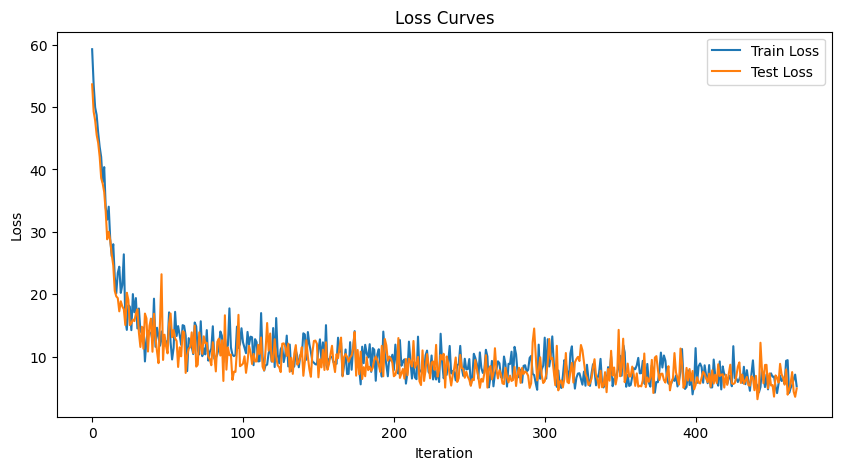

In [49]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [ ]:
total = 0
correct = 0

test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)
    
    test_spk, _ = net(data.view(data.size(0), -1))

    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 9307/10000
Test Set Accuracy: 93.07%
